In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

from kaggle_camera_model_id_lib.utils import PechkaBot, ImageList, NpzFolder, NCrops, TifFolderExFiles
from kaggle_camera_model_id_lib.models import VggHead, StyleVggHead, IEEEfcn, ResNetFC
from kaggle_camera_model_id_lib.utils import jpg_compress, equalize_v_hist, hsv_convert
from kaggle_camera_model_id_lib.utils import scale_crop_pad, gamma_correction

In [2]:
def view_model(model_path):
    checkpoint = torch.load(model_path)
    print(checkpoint['epoch'])
    for k, v in checkpoint['cfg'].items():
        print('%s = %s' % (k, str(v)))

    print('Loss train: %0.8f' % checkpoint['loss_train'][-1])
    print('Acc train: %0.8f' % checkpoint['acc_train'][-1])
    print('Loss acc: %0.8f' % checkpoint['loss_val'][-1])
    print('Val acc: %0.8f' % checkpoint['acc_val'][-1])
        
    plt.plot(checkpoint['loss_train'], 'r', label='loss train')
    plt.plot(checkpoint['acc_train'], 'r--', label='acc train')
    plt.plot(checkpoint['loss_val'], 'g', label='loss val')
    plt.plot(checkpoint['acc_val'], 'g--', label='acc val')
    for i in range(1, 1 + int(np.floor(checkpoint['epoch']/checkpoint['cfg']['lr_scheduler_step_size']))):
        plt.axvline(i*checkpoint['cfg']['lr_scheduler_step_size'] - 1, c='b', alpha=0.5)
    plt.legend()
    plt.show()

59
n_epoches = 1000
do_equalize_v_hist = False
crop_size = 256
do_hsv_convert = False
workers = 6
crop_center_size = 1520
out_dir = /home/mephistopheies/storage2/data/camera-model-id/tmp_msi
n_classes = 10
model_type = resnet18fc_pretrained
batch_size_train = 5
lr_scheduler_gamma = 0.5
learning_rate = 0.1
model_path = /home/mephistopheies/storage2/data/camera-model-id/models/resnet18fc/256_pretrained/best_model.tar
weight_decay = 0.0
n_crops_train = 30
do_random_aug_kaggle = True
step_crop_val = 128
lr_scheduler_step_size = 50
val_path = /home/mephistopheies/storage2/data/camera-model-id/val/
optim_type = sgd
momentum = 0.9
p_random_aug_kaggle = 0.5
train_list_path = /home/mephistopheies/storage2/data/camera-model-id/train.tsv
batch_size_val = 35
Loss train: 0.05061876
Acc train: 0.98378668
Loss acc: 0.25352040
Val acc: 0.91406594


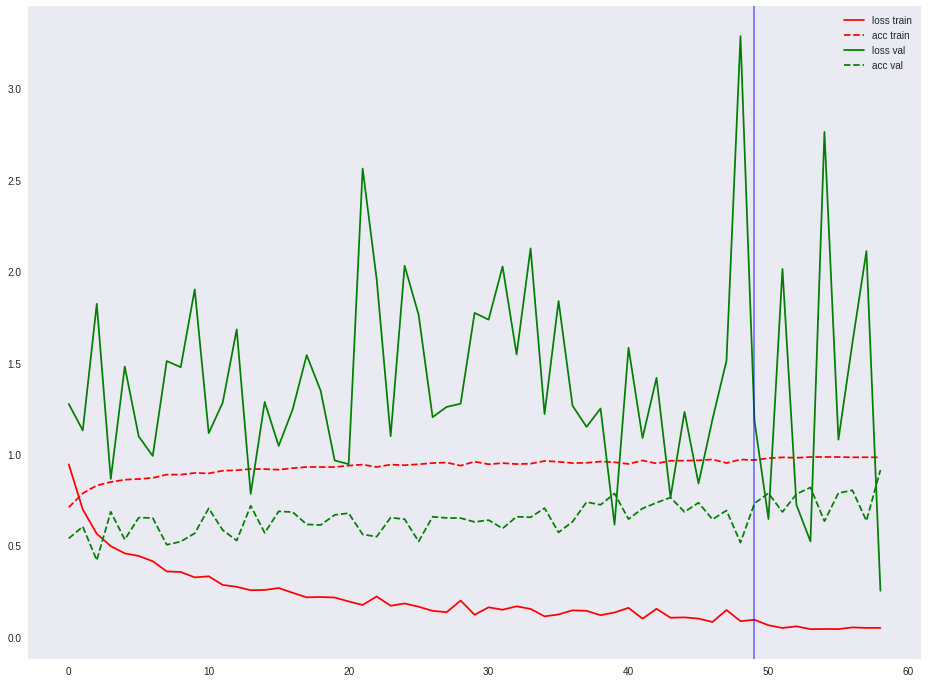

In [55]:
view_model('/home/mephistopheies/storage2/data/camera-model-id/tmp_msi/best_model.tar')

145
n_epoches = 1000
do_equalize_v_hist = False
crop_size = 256
do_hsv_convert = False
workers = 6
crop_center_size = 1520
out_dir = /home/mephistopheies/storage2/data/camera-model-id/tmp_msi
n_classes = 10
model_type = resnet18fc_pretrained
batch_size_train = 5
lr_scheduler_gamma = 0.5
learning_rate = 0.1
model_path = /home/mephistopheies/storage2/data/camera-model-id/models/resnet18fc/256_pretrained/best_model.tar
weight_decay = 0.0
n_crops_train = 30
do_random_aug_kaggle = True
step_crop_val = 128
lr_scheduler_step_size = 50
val_path = /home/mephistopheies/storage2/data/camera-model-id/val/
optim_type = sgd
momentum = 0.9
p_random_aug_kaggle = 0.5
train_list_path = /home/mephistopheies/storage2/data/camera-model-id/train.tsv
batch_size_val = 35
Loss train: 0.02371405
Acc train: 0.99302667
Loss acc: 0.42405606
Val acc: 0.86625153


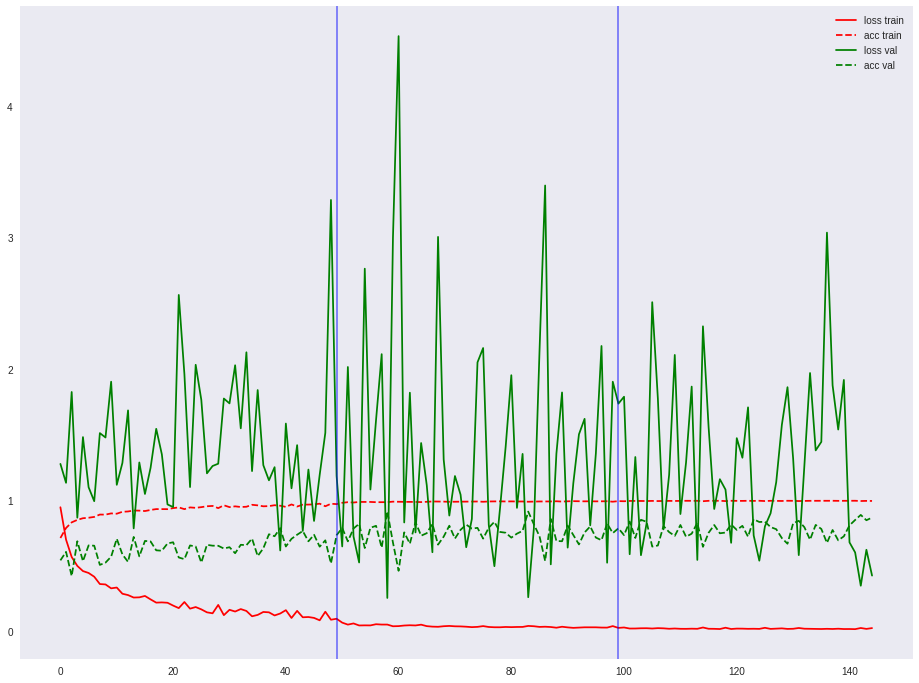

In [56]:
view_model('/home/mephistopheies/storage2/data/camera-model-id/tmp_msi/checkpoint.tar')

120
n_epoches = 1000
do_equalize_v_hist = False
crop_size = 256
weight_decay = 0.0
workers = 6
crop_center_size = 1520
batch_size_train = 5
out_dir = /home/mephistopheies/storage2/data/camera-model-id/tmp_zotac
n_classes = 10
do_hsv_convert = False
lr_scheduler_gamma = 0.5
n_crops_train = 15
model_path = None
do_random_aug_kaggle = True
learning_rate = 0.01
step_crop_val = 128
lr_scheduler_step_size = 25
model_type = InceptionResNetV2fcSmall_5_10
val_path = /home/mephistopheies/storage2/data/camera-model-id/val/
optim_type = sgd
momentum = 0.9
p_random_aug_kaggle = 1.0
train_list_path = /home/mephistopheies/storage2/data/camera-model-id/train.tsv
batch_size_val = 15
Loss train: 0.10673998
Acc train: 0.97010668
Loss acc: 0.63994955
Val acc: 0.80316048


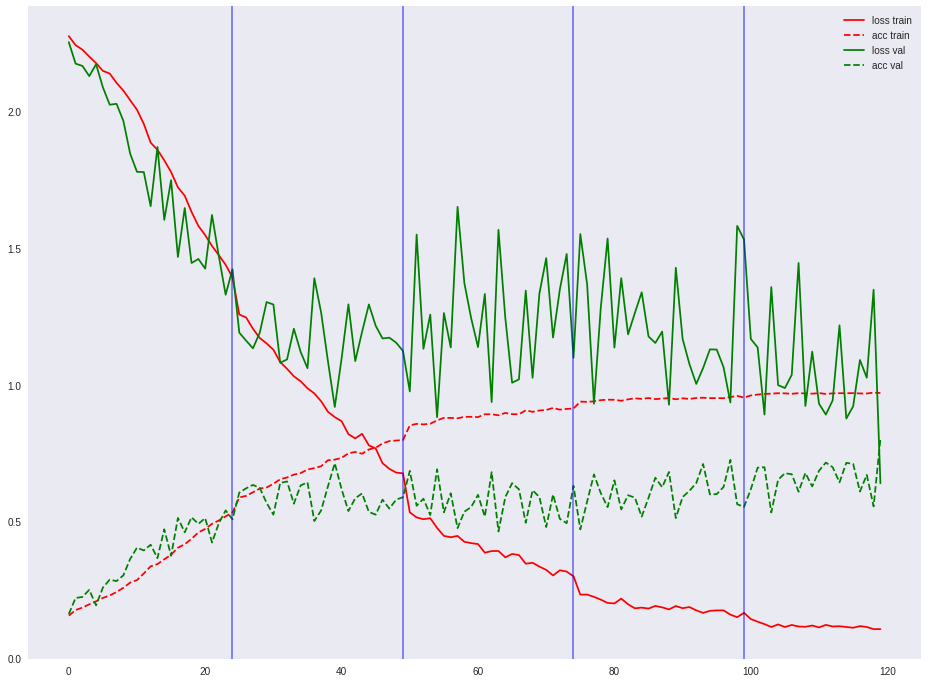

In [57]:
view_model('/home/mephistopheies/storage2/data/camera-model-id/tmp_zotac/best_model.tar')

145
n_epoches = 1000
do_equalize_v_hist = False
crop_size = 256
weight_decay = 0.0
workers = 6
crop_center_size = 1520
batch_size_train = 5
out_dir = /home/mephistopheies/storage2/data/camera-model-id/tmp_zotac
n_classes = 10
do_hsv_convert = False
lr_scheduler_gamma = 0.5
n_crops_train = 15
model_path = None
do_random_aug_kaggle = True
learning_rate = 0.01
step_crop_val = 128
lr_scheduler_step_size = 25
model_type = InceptionResNetV2fcSmall_5_10
val_path = /home/mephistopheies/storage2/data/camera-model-id/val/
optim_type = sgd
momentum = 0.9
p_random_aug_kaggle = 1.0
train_list_path = /home/mephistopheies/storage2/data/camera-model-id/train.tsv
batch_size_val = 15
Loss train: 0.08632541
Acc train: 0.97682668
Loss acc: 1.07463020
Val acc: 0.62740740


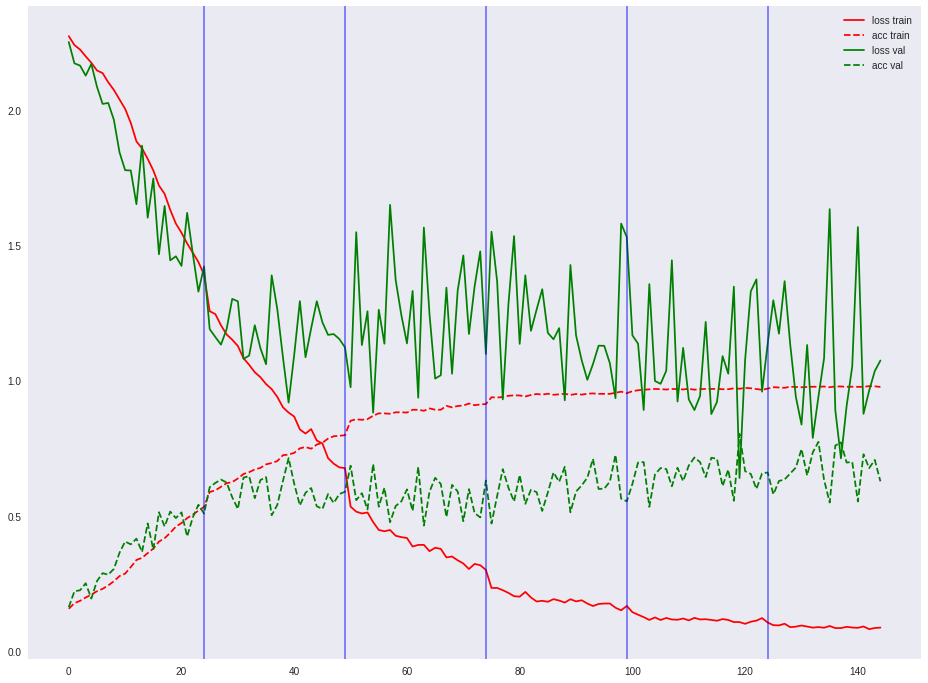

In [58]:
view_model('/home/mephistopheies/storage2/data/camera-model-id/tmp_zotac/checkpoint.tar')

218
workers = 6
n_epoches = 1000
do_equalize_v_hist = False
crop_size = 256
train_list_path = /home/mephistopheies/storage2/data/camera-model-id/train.tsv
model_type = resnet18fc_pretrained
crop_center_size = 1520
batch_size_train = 9
out_dir = /home/mephistopheies/storage2/data/camera-model-id/tmp_zotac
n_classes = 10
do_hsv_convert = False
lr_scheduler_gamma = 0.5
learning_rate = 0.1
model_path = None
weight_decay = 0.0
n_crops_train = 25
do_random_aug_kaggle = True
step_crop_val = 128
lr_scheduler_step_size = 50
val_path = /home/mephistopheies/storage2/data/camera-model-id/val/
optim_type = sgd
momentum = 0.9
p_random_aug_kaggle = 1.0
batch_size_val = 50
Loss train: 0.01346973
Acc train: 0.99593926
Loss acc: 0.08461804
Val acc: 0.97387656


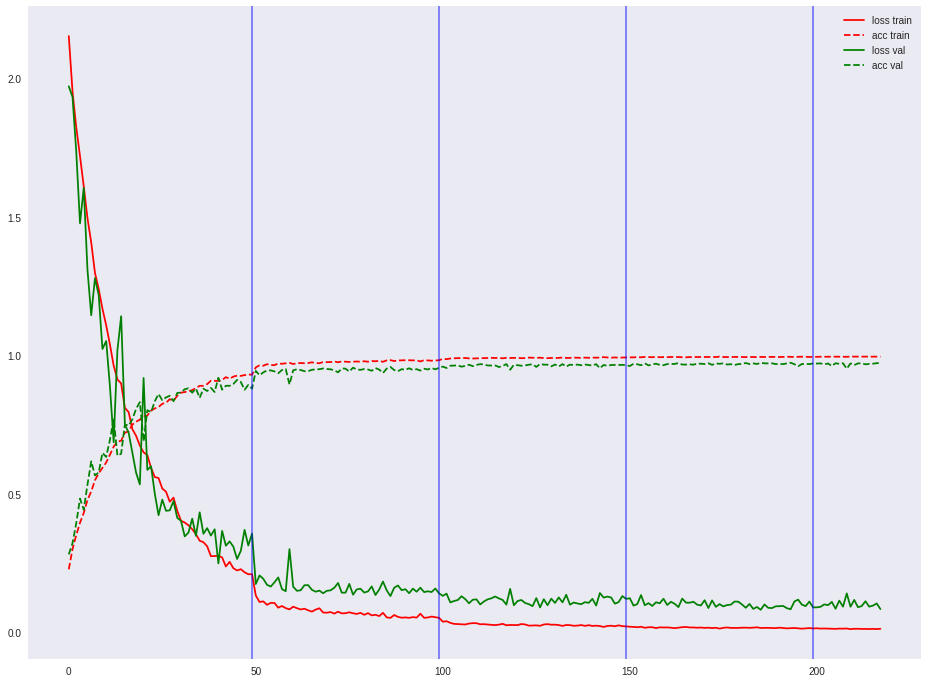

In [59]:
view_model('/home/mephistopheies/storage2/data/camera-model-id/models/resnet18fc/256_pretrained_random_aug_kaggle_10/best_model.tar')

207
n_epoches = 1000
do_equalize_v_hist = False
crop_size = 256
weight_decay = 0.0
workers = 4
learning_rate = 0.1
batch_size_train = 5
out_dir = /home/mephistopheies/storage2/data/camera-model-id/tmp_msi
n_classes = 10
crop_center_size = 1520
do_hsv_convert = False
lr_scheduler_gamma = 0.5
n_crops_train = 7
model_path = /home/mephistopheies/storage2/data/camera-model-id/models/Vgg19Head_E_3b_bn/256/best_model.tar
do_random_aug_kaggle = True
step_crop_val = 128
model_type = Vgg19Head_E_3b_bn
val_path = /home/mephistopheies/storage2/data/camera-model-id/val/
optim_type = sgd
momentum = 0.9
lr_scheduler_step_size = 50
train_list_path = /home/mephistopheies/storage2/data/camera-model-id/train.tsv
batch_size_val = 15
Loss train: 0.25857507
Acc train: 0.92640000
Loss acc: 0.20984081
Val acc: 0.94424690


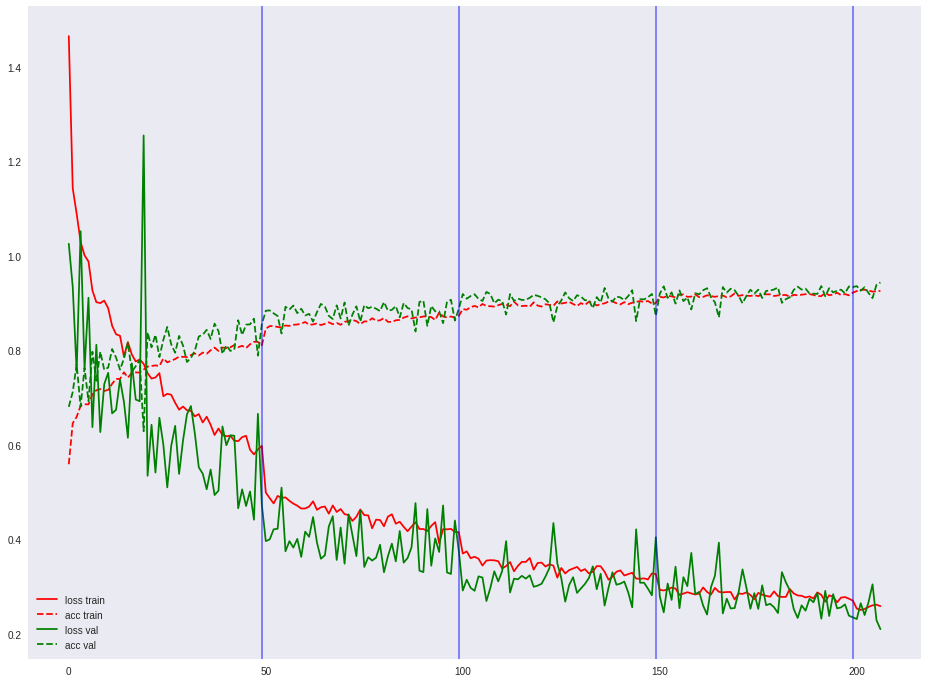

In [60]:
view_model('/home/mephistopheies/storage2/data/camera-model-id/models/Vgg19Head_E_3b_bn/256_do_random_aug_kaggle_05/best_model.tar')

39
n_epoches = 1000
do_random_aug_kaggle = True
momentum = 0.9
model_type = resnet18fc_pretrained
crop_size = 384
weight_decay = 0.0
out_dir = /home/mephistopheies/storage2/data/camera-model-id/tmp_zotac
do_hsv_convert = False
crop_center_size = 1520
batch_size_train = 9
n_crops_train = 12
workers = 6
lr_scheduler_gamma = 0.5
p_random_aug_kaggle = 1.0
do_equalize_v_hist = False
learning_rate = 0.01
val_path = /home/mephistopheies/storage2/data/camera-model-id/val/
model_path = /home/mephistopheies/storage2/data/camera-model-id/models/resnet18fc/256_pretrained_random_aug_kaggle_10/best_model.tar
train_list_path = /home/mephistopheies/storage2/data/camera-model-id/train.tsv
n_classes = 10
batch_size_val = 10
optim_type = sgd
step_crop_val = 128
lr_scheduler_step_size = 25
Loss train: 0.00401275
Acc train: 0.99866774
Loss acc: 0.04305480
Val acc: 0.98722223


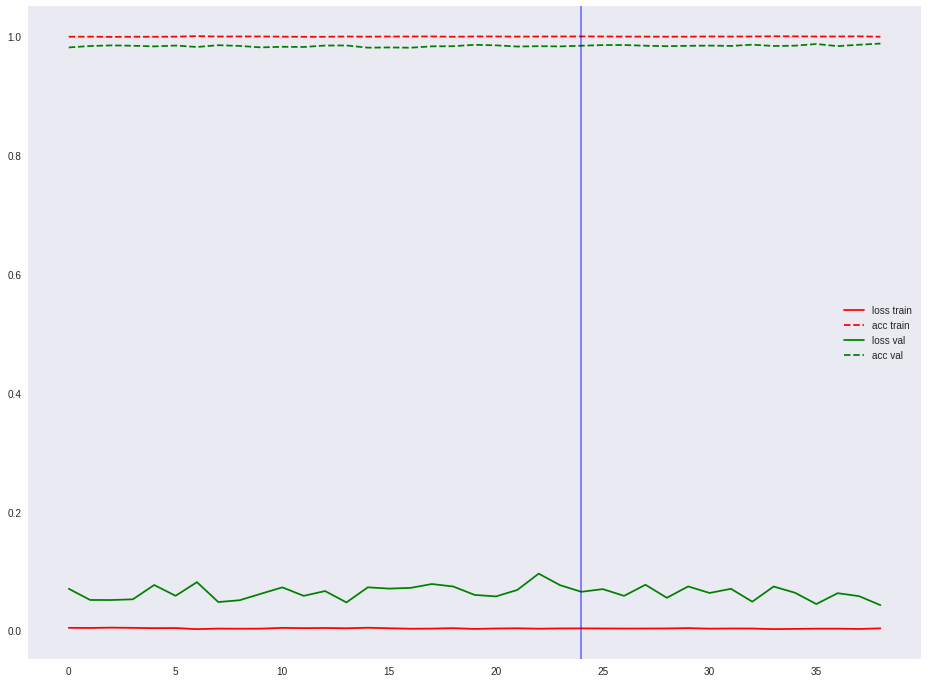

In [3]:
view_model('/home/mephistopheies/storage2/data/camera-model-id/models/resnet18fc/384_pretrained_random_aug_kaggle_10/best_model.tar')